| Morphogen gradient parameter      | Scaling   |
|-----------------------------------|-----------|
| $ w $ for SHH                     | static    | 
| $ x_0 $ for SHH                   | static    | 
| $ \lambda $ for SHH               | static    |
| $ w $ for FGF8                    | static    | 
| $ x_0 $ for FGF8                  | static    | 
| $ \lambda $ for FGF8              | static    | 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

In [3]:
# function for numerical scheme in custom package 
from euler_scheme_1d_with_growth.analytical_solutions import steady_solution, nrect
from euler_scheme_1d_with_growth.two_morph import Lfinal
import matplotlib.patches as patches

In [4]:
from euler_scheme_1d_with_growth.matplotlib_defaults import *

In [5]:
# assume to be 1
D0      = 1
beta0   = 1
alpha0  = 1
lam0    = math.sqrt(D0/beta0) 

L_to_plot = [1.8 * lam0, 3.6 * lam0]

# supported by experiments
x00    = 0.4*lam0
w0     = 0.4*lam0


# proportionality coefficient for scaling

b_lam   = lam0 / L_to_plot[0]
b_xw    = x00 / L_to_plot[0]
b_alpha = alpha0 / min(L_to_plot)

sc_lam_keys = ['no', 'D', 'mixed', 'beta']
sc_s_keys   = ['', 'x', 'a', 'w', 'ax', 'xw', 'aw', 'axw']

color_scheme = {
    "no":    mcolors.to_rgb("black"),
    "D":     mcolors.to_rgb("cyan"),
    "mixed": mcolors.to_rgb("orange"),
    "beta":  mcolors.to_rgb("magenta")
}

def scaling_lam(b_lam, D0, beta0, alpha0, L):
    return {
        "no": {
            "lambda": math.sqrt(D0 / beta0),
            "beta":   beta0,
            "D":      D0
        },
        "D": {
            "lambda": b_lam * L,
            "beta":   beta0,
            "D":      beta0 * (b_lam * L)**2
        },
        "mixed": {
            "lambda": b_lam * L,
            "beta":   (beta0 * math.sqrt(D0 / beta0)) / (b_lam * L),
            "D":      (D0 * (b_lam * L)) / math.sqrt(D0 / beta0)
        },
        "beta": {
            "lambda": b_lam * L,
            "beta":   D0 / (b_lam * L)**2,
            "D":      D0
        }
    }

# Add elements function
def add_elements(x, y):
    return x + y if x == 0 else x

def scaling_source(b_xw, b_alpha, L, alpha0, x0, w0):
    sources = {}
    for i in range(2**3):  # 2^3 = 8 combinations
        binary_digits = [int(d) for d in f"{i:03b}"]  # Convert to 3-digit binary
        keys = "".join([char for char, digit in zip("axw", binary_digits) if digit])

        values = {
            "a":  add_elements(binary_digits[0] * (b_alpha * L), alpha0),
            "x0": add_elements(binary_digits[1] * (b_xw * L),    x00   ),
            "w":  add_elements(binary_digits[2] * (b_xw * L),    w0    )
        }

        sources[keys] = values
        
    return sources

In [6]:
threshold = 0.1

# Plot

In [7]:
def plot_cmiddle(ax, row, Lx, sc_s_key, sc_lam_keys, color_scheme, b_lam, b_xw, b_alpha, alpha0, x0, w0, beta0, D0, scaling_source, scaling_lam, steady_solution):
    """Plot center middle values for each scaling key."""
    for sc_lam_key in sc_lam_keys:
        A = []
        for L in Lx:
            sc_s   = scaling_source(b_xw, b_alpha, L, alpha0, x00, w0)[sc_s_key]
            sc_lam = scaling_lam(b_lam, D0, beta0, alpha0, L)[sc_lam_key]
            x = np.linspace(0, L)
            A.append(steady_solution(L / 2, sc_s['x0'], sc_lam['lambda'], sc_s['a'], sc_s['w'], sc_lam['beta'], sc_lam['D'], L))
        ax[row, 0].plot(Lx, A, color=np.array(color_scheme[sc_lam_key]))
        
        ax[row, 0].set_ylabel(sc_s_key)  
        ax[row, 0].set_yticks([])
        
        ax[row, 0].set_xlim(0, 4*L_to_plot[0])
        ax[row, 0].set_xticks([0, L_to_plot[0], L_to_plot[1], 3*L_to_plot[0], 4*L_to_plot[0]])  # Set the tick positions
        ax[row, 0].set_ylim(0, 1)
        if row == 0:
            ax[row, 0].set_title('cmiddle')

In [8]:
def plot_Lfinal(ax, row, Lx, sc_s_key, sc_lam_keys, color_scheme, b_lam, b_xw, b_alpha, alpha0, x00, w0, beta0, D0, scaling_source, scaling_lam, steady_solution, start_col=0):
    """Plot center middle values for each scaling key."""
    for sc_lam_key in sc_lam_keys:
        Lf = []
        for L0 in Lx:
            sc_s   = scaling_source(b_xw, b_alpha, L0, alpha0, x00, w0)[sc_s_key]
            sc_lam = scaling_lam(b_lam, D0, beta0, alpha0, L0)[sc_lam_key]

            Lf.append( Lfinal(threshold, sc_s['x0'], sc_lam['lambda'], sc_s['a'], sc_s['w'], sc_lam['beta'], sc_lam['D']) )
            
        ax[row, start_col+1].plot(Lx, Lf, color=np.array(color_scheme[sc_lam_key]))
        ax[row, start_col+1].fill_between( np.linspace(0, 20, 100), 0, np.linspace(0, 20, 100), color='Lightgray') 

        ax[row, start_col+1].set_xlim(0, 6*L_to_plot[0])
        ax[row, start_col+1].set_ylim(0, 6*L_to_plot[0])
        ax[row, start_col+1].set_xticks([0, 2*L_to_plot[0], 4*L_to_plot[0], 6*L_to_plot[0]])  # Set the tick positions
        ax[row, start_col+1].set_yticks([0, 2*L_to_plot[0], 4*L_to_plot[0], 6*L_to_plot[0]])  # Set the tick positions
        #ax[row, start_col+1].set_yticks([])

        if row == 0:
            ax[row, start_col+1].set_title('Lfinal')

        # derivative
        # Plot the original line
        Lf_derivative = np.gradient(Lf, Lx)  # Computes d(Lf)/d(Lx)
        
        # Plot the derivative
        ax[row, start_col+2].plot(Lx, Lf_derivative, color=np.array(color_scheme[sc_lam_key]))
        ax[row, start_col+2].set_ylim(0, 8)
        #ax[row, start_col+2].set_yticks([])
        
        if row == 0:
            ax[row, start_col+2].set_title('derLfinal')

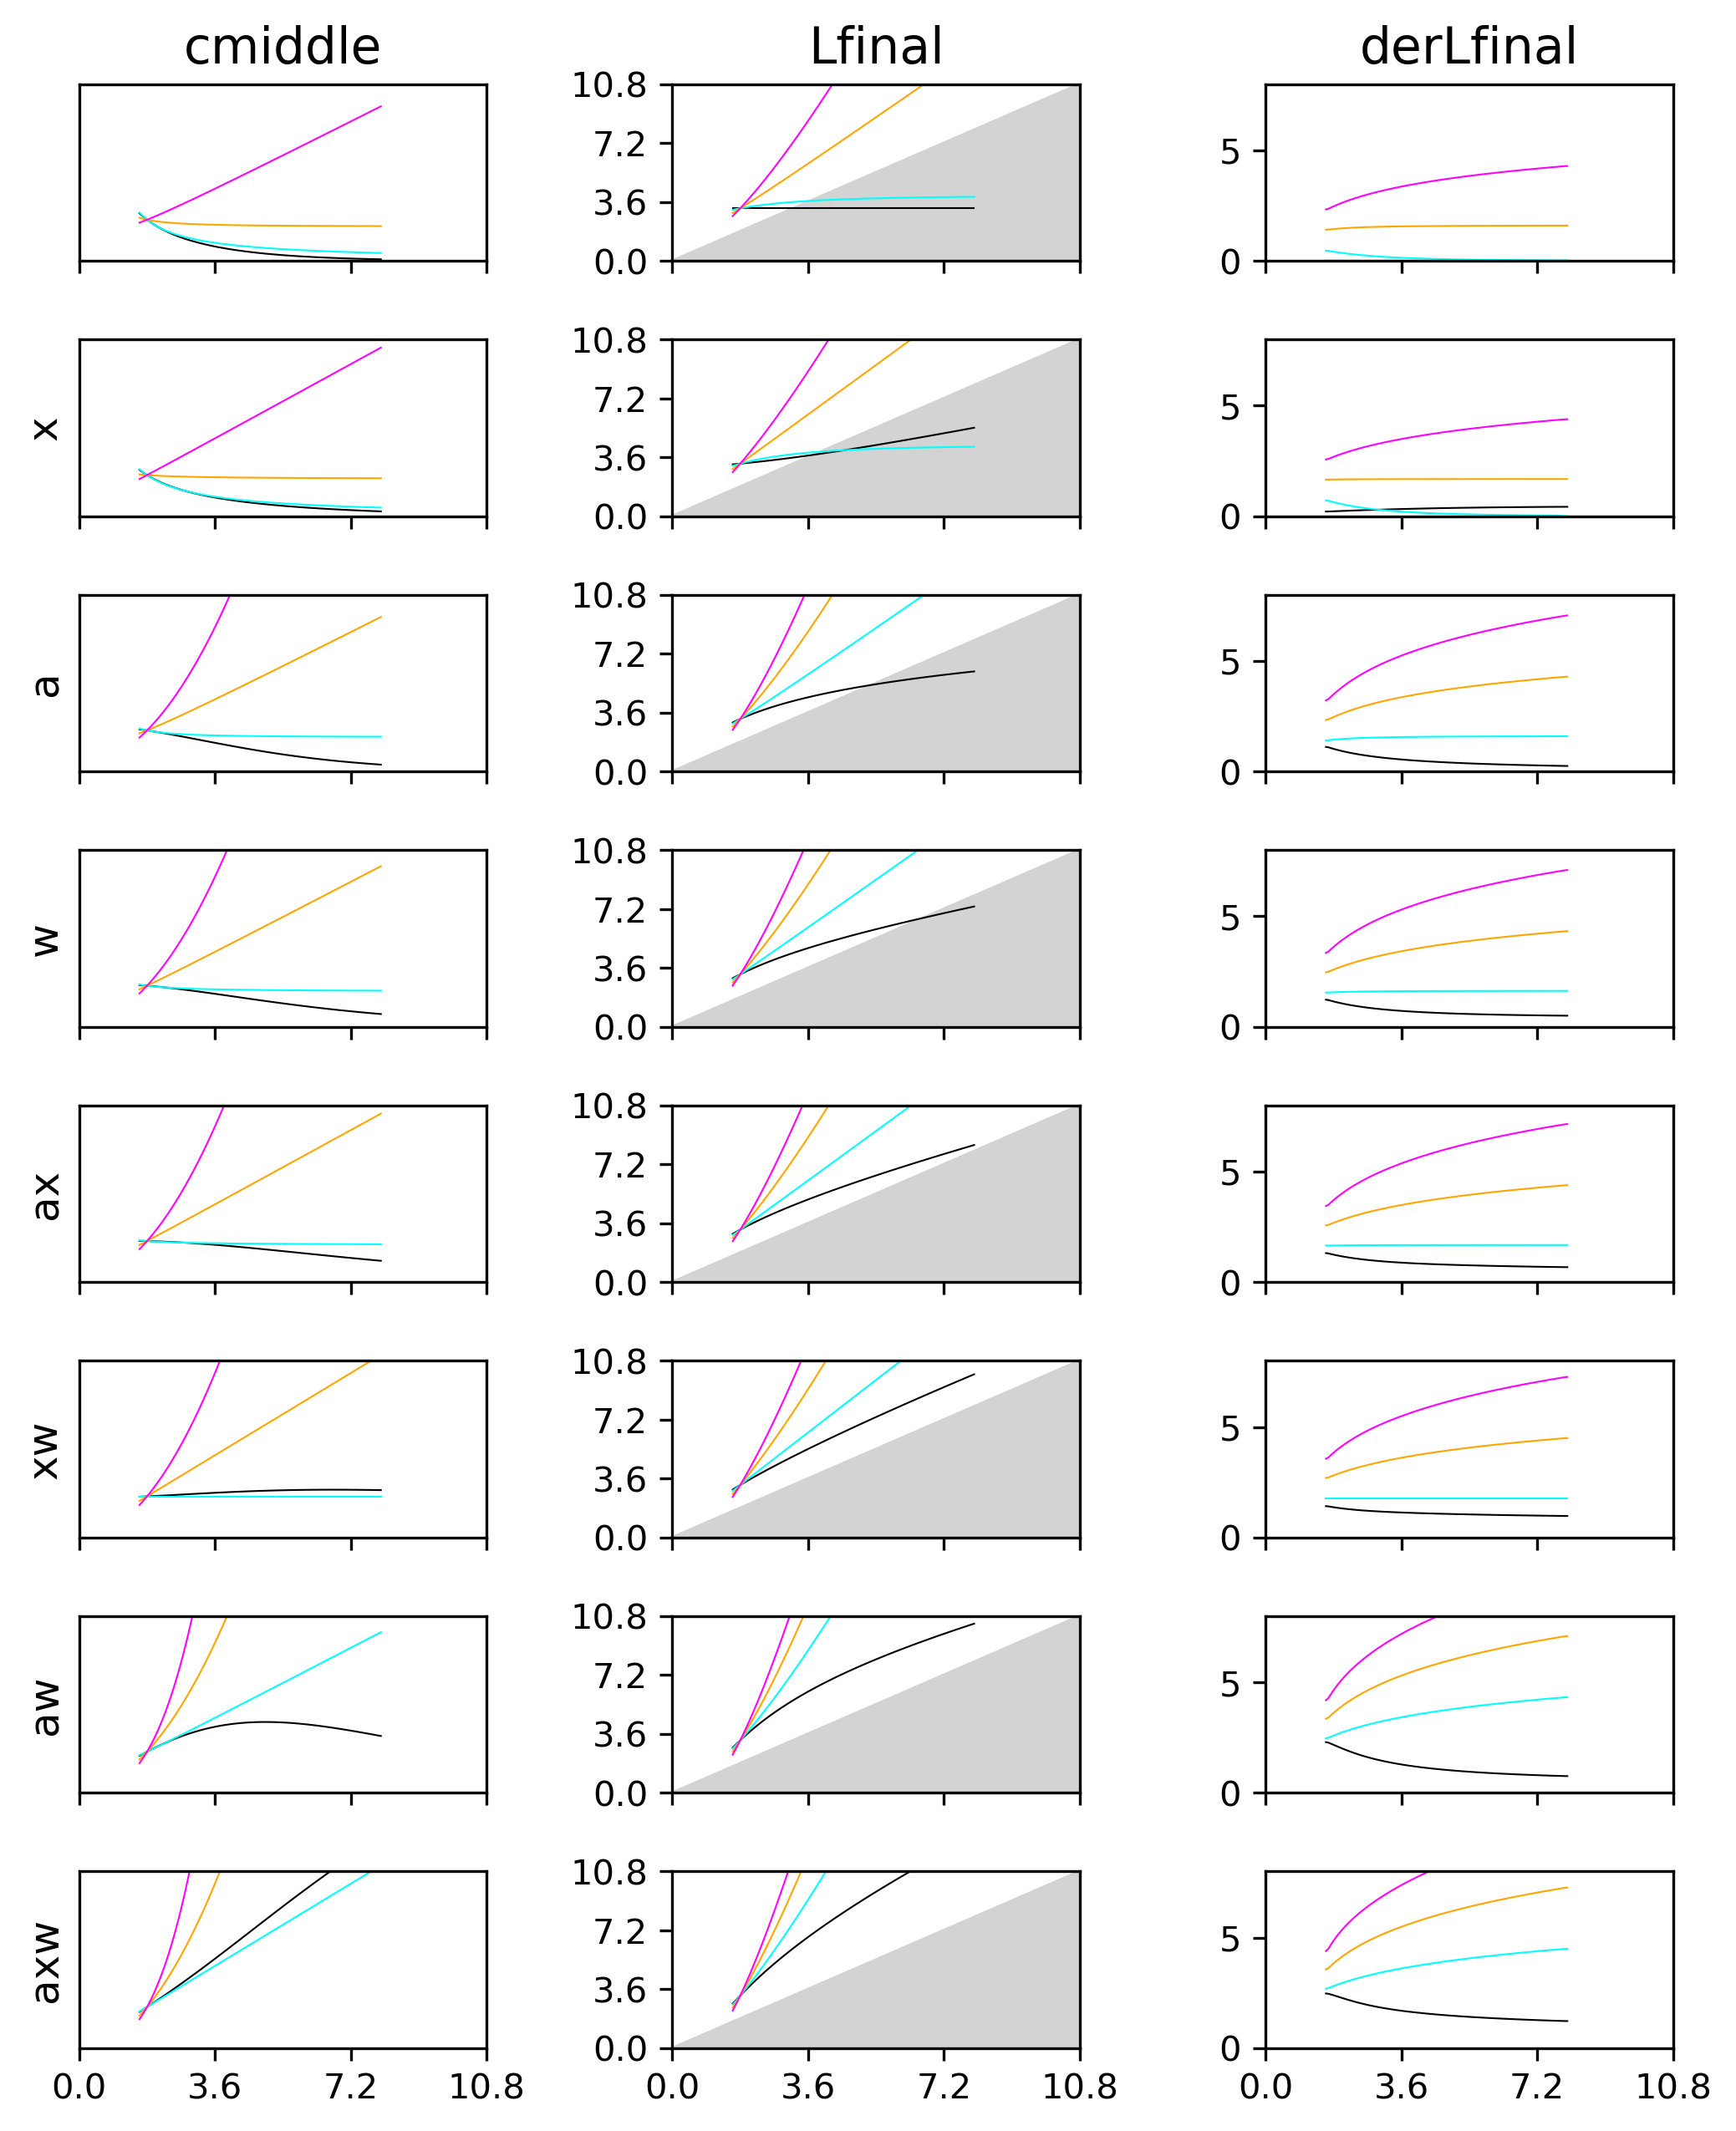

In [9]:
nrows, ncols = 8, 3

fig, ax = plt.subplots(nrows, ncols, figsize=(default_figsize["large"][0], default_figsize["large"][1]), sharex=True, sharey=False)

Lx = np.linspace( 2*(x00 + w0), 8, 100 )

for i, sc_s_key in enumerate(sc_s_keys):
    plot_cmiddle(ax, i, Lx, sc_s_key, sc_lam_keys, color_scheme, b_lam, b_xw, b_alpha, alpha0, x00, w0, beta0, D0, scaling_source, scaling_lam, steady_solution)
    plot_Lfinal( ax, i, Lx, sc_s_key, sc_lam_keys, color_scheme, b_lam, b_xw, b_alpha, alpha0, x00, w0, beta0, D0, scaling_source, scaling_lam, steady_solution)

plt.tight_layout()
plt.savefig( 'fig/static_scaling_two.pdf' )
plt.show()

# Plots

In [10]:
# just to get plot scale

sc_s   = scaling_source(b_xw, b_alpha, L_to_plot[-1], alpha0, x00, w0)['xw']
sc_lam = scaling_lam(b_lam, D0, beta0, alpha0, L_to_plot[-1])['beta']

Lmax = Lfinal(threshold, sc_s['x0'], sc_lam['lambda'], sc_s['a'], sc_s['w'], sc_lam['beta'], sc_lam['D'])

In [11]:
def plot_steady_solutions(ax, i, sc_s_keys, sc_lam_keys, L0, color_scheme, b_lam, b_xw, b_alpha, alpha0, x00, w0, beta0, D0, scaling_source, scaling_lam, steady_solution):
    """Plot steady solutions for each combination of scaling keys and L values."""
    sc_s_key = 'xw'
    for j, sc_lam_key in enumerate(sc_lam_keys):

        # parm depend on initial size L0

        sc_s   = scaling_source( b_xw, b_alpha, L0, alpha0, x00, w0)['xw']
        sc_lam = scaling_lam(    b_lam, D0, beta0, alpha0, L0)[sc_lam_key]

        x = np.linspace(0, L0)
        ax[i, j].plot(
            x,
            steady_solution(x, sc_s['x0'], sc_lam['lambda'], sc_s['a'], sc_s['w'], sc_lam['beta'], sc_lam['D'], L0),
            color=np.array(color_scheme[sc_lam_key]) * (1 - 0.5 * L0 / max(L_to_plot))
        )

        Lf = Lfinal(threshold, sc_s['x0'], sc_lam['lambda'], sc_s['a'], sc_s['w'], sc_lam['beta'], sc_lam['D'])

        x = np.linspace(0, Lf)
        ax[i, j].plot(
            x,
            steady_solution(x, sc_s['x0'], sc_lam['lambda'], sc_s['a'], sc_s['w'], sc_lam['beta'], sc_lam['D'], Lf),
            color=np.array(color_scheme[sc_lam_key]) * (1 - 0.5 * L0 / max(L_to_plot))
        )

        rect = patches.Rectangle( 
                (sc_s['x0'], 0), sc_s['w'], 0.02*sc_s['a'] / sc_s['w'], 
                color=np.array(color_scheme[sc_lam_key]) * (1 - 0.5 * L_to_plot[i] / max(L_to_plot) )
            )
        
        ax[i, j].add_patch( rect )
        
        ax[i, j].set_xlim(0, Lmax)
        ax[i, j].set_ylim(0, 1.2)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])

        if j == 0:
            ax[i, j].set_ylabel(sc_s_key)

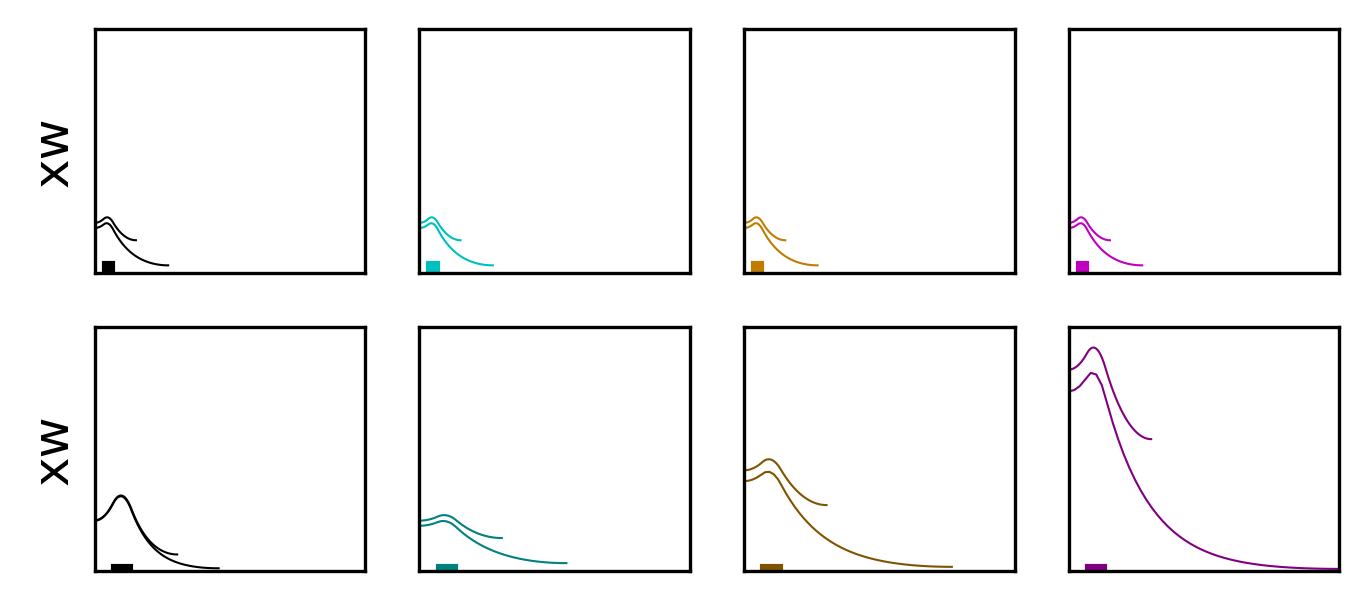

In [12]:
nrows, ncols = 2, 4

fig, ax = plt.subplots(nrows, ncols, figsize=(4/6*default_figsize["large"][0], default_figsize["large"][1]/4), sharex=False, sharey=False)

Lx = np.linspace( 2*(x00 + w0), 8, 100 )

i = 0
L0 = L_to_plot[0]
plot_steady_solutions(ax, i, sc_s_keys, sc_lam_keys, L0, color_scheme, b_lam, b_xw, b_alpha, alpha0, x00, w0, beta0, D0, scaling_source, scaling_lam, steady_solution)


i = 1
L0 = L_to_plot[1]
plot_steady_solutions(ax, i, sc_s_keys, sc_lam_keys, L0, color_scheme, b_lam, b_xw, b_alpha, alpha0, x00, w0, beta0, D0, scaling_source, scaling_lam, steady_solution)

plt.tight_layout()
plt.savefig( 'fig/static_scaling_two_plots.pdf' )
plt.show()

In [13]:
Lmax / L0

3.2801260297770867

In [14]:
L0

3.6